<a href="https://colab.research.google.com/github/zahra-sharifzadeh/pytorch/blob/main/ML_2023/MNIST_Classifier_ML_2023.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PyTorch Convolutional Neural Network With MNIST Dataset
We are going to use PYTorch and create CNN model step by step. Then we will train the model with training data and evaluate the model with test data.

##Import libraries

In [139]:
import torch

##Check device is available

In [140]:
# Setting the device
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

##Download MNIST dataset


*   PyTorch domain libraries provide a number of pre-loaded datasets (such as FashionMNIST, MNIST etc…) that subclass torch.utils.data.Dataset and implement functions specific to the particular data
*   **ToTensor**: Converts a PIL Image or numpy.ndarray (H x W x C) in the range [0, 255] to a torch.FloatTensor of shape (C x H x W) in the range [0.0, 1.0]



In [141]:
from torchvision import datasets
from torchvision.transforms import ToTensor

train_data = datasets.MNIST(
    root = 'data',
    train = True,
    transform = ToTensor(),
    download = True,
)
test_data = datasets.MNIST(
    root = 'data',
    train = False,
    transform = ToTensor()
)

In [142]:
print(train_data)
print(train_data.data.size())
print(train_data.targets.size())



Dataset MNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()
torch.Size([60000, 28, 28])
torch.Size([60000])


In [143]:
print(test_data)


Dataset MNIST
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: ToTensor()


##Visualization of MNIST dataset
Fixing shape of image to plot
(C x H x W) -> (H x W x C)

In [144]:
train_data[0][0].shape

torch.Size([1, 28, 28])

In [145]:
train_data[0][0].squeeze(dim=0).shape

torch.Size([28, 28])

In [146]:
image_permuted = train_data[0][0].permute(1, 2, 0) # (C x H x W) -> (H x W x C)
image_permuted.shape

torch.Size([28, 28, 1])

In [147]:
image_view  = train_data[0][0].view(28, 28, -1) # (C x H x W) -> (H x W x C)
image_view.shape

torch.Size([28, 28, 1])

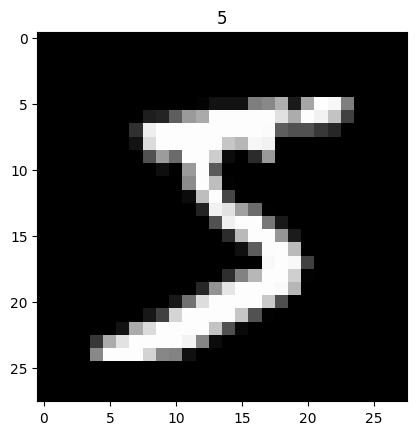

In [148]:
import matplotlib.pyplot as plt
plt.imshow(train_data[0][0].squeeze(dim=0), cmap='gray')
plt.title(train_data.targets[0].item())
plt.show()

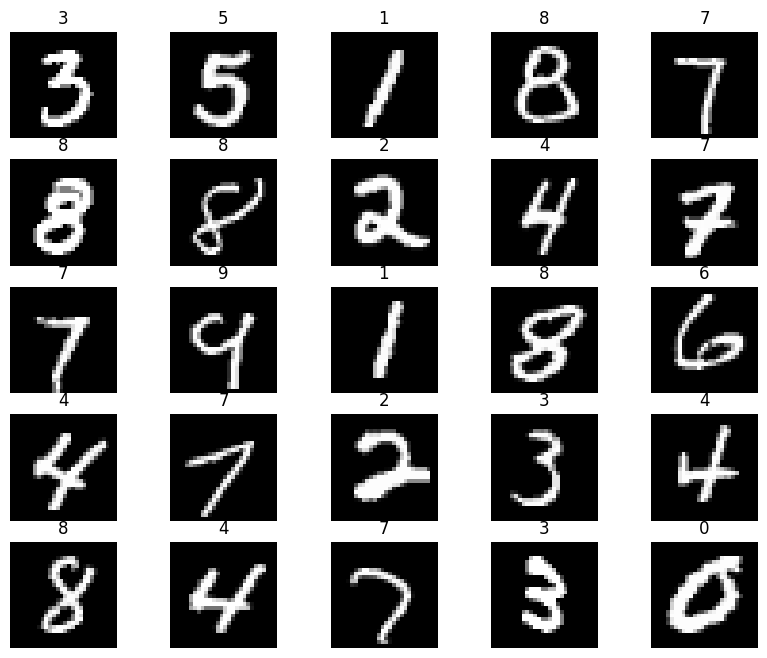

In [149]:
figure = plt.figure(figsize=(10, 8))
cols, rows = 5, 5
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_data), size=(1,)).item()
    img, label = train_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

## Preparing data for training with DataLoaders
* we typically want to pass samples in “minibatches”, reshuffle the
data at every epoch to reduce model overfitting, and use Python’s multiprocessing to speed up data retrieval.

* DataLoader is an iterable.

In [150]:
from torch.utils.data import DataLoader
loaders = {
    'train' : torch.utils.data.DataLoader(train_data,
                                          batch_size=100,
                                          shuffle=True,
                                          num_workers=1),

    'test'  : torch.utils.data.DataLoader(test_data,
                                          batch_size=100,
                                          shuffle=False,
                                          num_workers=1),
}
loaders

{'train': <torch.utils.data.dataloader.DataLoader at 0x7f7b38b39240>,
 'test': <torch.utils.data.dataloader.DataLoader at 0x7f7b3895d2a0>}

In [151]:
# Check out what 's inside the training dataloader
train_features_batch, train_labels_batch = next(iter(loaders['train']))
train_features_batch.shape, train_labels_batch.shape

(torch.Size([100, 1, 28, 28]), torch.Size([100]))

##Define the Convolutional Neural Network model

Parameters

in_channels (int) — Number of channels in the input image

out_channels (int) — Number of channels produced by the convolution

kernel_size (int or tuple) — Size of the convolving kernel

stride (int or tuple, optional) — Stride of the convolution. Default: 1

padding (int or tuple, optional) — Zero-padding added to both sides of the input. Default: 0

padding_mode (string, optional) — ‘zeros’, ‘reflect’, ‘replicate’ or ‘circular’. Default: ‘zeros’

dilation (int or tuple, optional) — Spacing between kernel elements. Default: 1

groups (int, optional) — Number of blocked connections from input channels to output channels. Default: 1

bias (bool, optional) — If True, adds a learnable bias to the output. Default: True

In [152]:
import torch.nn as nn
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(
                in_channels=1,
                out_channels=16,
                kernel_size=5,
                stride=1,
                padding=2,
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(16, 32, 5, 1, 2),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        # fully connected layer, output 10 classes
        self.flatten = nn.Flatten()

        self.linear = nn.Linear(32 * 7 * 7, 10)

        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        # flatten the output of conv2 to (batch_size, 32 * 7 * 7)
        x = self.flatten (x)
        logits = self.linear(x)

        return logits   # return x for visualization

* in_channels=1: because our input is a grayscale image.

* Stride: is the number of pixels to pass at a time when sliding the convolutional kernel.

* Padding: to preserve exactly the size of the input image, it is useful to add a zero padding on the border of the image.

* kernel_size: we need to define a kernel which is a small matrix of size 5 * 5. To perform the convolution operation, we just need to slide the kernel along the image horizontally and vertically and do the dot product of the kernel and the small portion of the image.

* The forward() pass defines the way we compute our output using the given layers and functions.

In [153]:
cnn = CNN().to(device)
print(cnn)

CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear): Linear(in_features=1568, out_features=10, bias=True)
  (softmax): Softmax(dim=1)
)


##Use torchinfo to get an idea of the shape going through our model

In [154]:
try:
  from torchinfo import summary

except:
    !pip install torchinfo
    from torchinfo import summary

In [155]:
summary(cnn, input_size=[1, 1, 28, 28])


Layer (type:depth-idx)                   Output Shape              Param #
CNN                                      [1, 10]                   --
├─Sequential: 1-1                        [1, 16, 14, 14]           --
│    └─Conv2d: 2-1                       [1, 16, 28, 28]           416
│    └─ReLU: 2-2                         [1, 16, 28, 28]           --
│    └─MaxPool2d: 2-3                    [1, 16, 14, 14]           --
├─Sequential: 1-2                        [1, 32, 7, 7]             --
│    └─Conv2d: 2-4                       [1, 32, 14, 14]           12,832
│    └─ReLU: 2-5                         [1, 32, 14, 14]           --
│    └─MaxPool2d: 2-6                    [1, 32, 7, 7]             --
├─Flatten: 1-3                           [1, 1568]                 --
├─Linear: 1-4                            [1, 10]                   15,690
├─Softmax: 1-5                           [1, 10]                   --
Total params: 28,938
Trainable params: 28,938
Non-trainable params: 0
Total 

## Define a Optimization Function


In [156]:
from torch import optim
optimizer = optim.Adam(cnn.parameters(), lr = 0.01)
optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.01
    maximize: False
    weight_decay: 0
)

## Define loss function

In [157]:
loss_func = nn.CrossEntropyLoss()
loss_func

CrossEntropyLoss()

In [163]:
from torch.autograd import Variable
num_epochs = 10
def train_step(num_epochs, cnn, loaders):

    cnn.train()

    # Train the model
    total_step = len(loaders['train'])

    for epoch in range(num_epochs):
        for i, (images, labels) in enumerate(loaders['train']):

            images, labels = images.to(device), labels.to(device)

            output = cnn(images)
            loss = loss_func(output, labels)

            # clear gradients for this training step
            optimizer.zero_grad()

            # backpropagation, compute gradients
            loss.backward()
            # apply gradients
            optimizer.step()


        print (f'Epoch [{epoch + 1}/{num_epochs}]], Loss: {loss.item()}')



In [164]:
train_step(num_epochs, cnn, loaders)

Epoch [1/10]], Loss: 0.0018762078834697604
Epoch [2/10]], Loss: 0.09251820296049118
Epoch [3/10]], Loss: 0.02688295766711235
Epoch [4/10]], Loss: 0.1386152058839798
Epoch [5/10]], Loss: 0.0879986509680748
Epoch [6/10]], Loss: 0.11611919105052948
Epoch [7/10]], Loss: 7.645675941603258e-05
Epoch [8/10]], Loss: 0.013197146356105804
Epoch [9/10]], Loss: 0.0006241874652914703
Epoch [10/10]], Loss: 0.00043219118379056454


In [173]:
def test_step(
    model : torch.nn.Module,
    data_loader: torch.utils.data.DataLoader,
    loss_fn: torch.nn.Module,
    device: torch.device = device):
    ### Testing
  test_loss, test_acc = 0, 0
  model.to(device)

  model.eval()




  with torch.inference_mode():

    for X_test, y_test in data_loader:
      X_test, y_test = X_test.to(device), y_test.to(device)

      test_pred = model(X_test)

      test_loss += loss_fn(test_pred, y_test)

    test_loss /= len(data_loader)

    print(f"Test loss:{test_loss:.5f}% ")

In [174]:
test_step(
    cnn,
    loaders["test"],
    loss_func,
    device)

Test loss:0.08619% 


## Print 10 predictions from test data


In [183]:
sample = next(iter(loaders['test']))
imgs, lbls = sample

actual_number = lbls[:10]

In [186]:
imgs, lbls = imgs.to(device), lbls.to(device)
test_output = cnn(imgs[:10])
pred_y = torch.argmax(test_output, dim=1)
print(f'Prediction number: {pred_y}')
print(f'Actual number: {actual_number}')

Prediction number: tensor([7, 2, 1, 0, 4, 1, 4, 9, 5, 9], device='cuda:0')
Actual number: tensor([7, 2, 1, 0, 4, 1, 4, 9, 5, 9])
